In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pylab as plt
%matplotlib inline
import Bio

In [2]:
print("Biopython v" + Bio.__version__)

Biopython v1.76


## First look at sequences

In [3]:
from Bio.Seq import Seq
sequence = Seq("AAGTTAGATCGATTACACTAGT")
print(sequence)


AAGTTAGATCGATTACACTAGT


In [4]:
seqalph = sequence.alphabet

In [5]:
seqalph.letters,seqalph.size 

(None, None)

In [6]:
print('{} | Sequence '.format(sequence))
print('{} | Complement '.format(sequence.complement()))
print('{} | Reverse complement '.format(sequence.reverse_complement()))

AAGTTAGATCGATTACACTAGT | Sequence 
TTCAATCTAGCTAATGTGATCA | Complement 
ACTAGTGTAATCGATCTAACTT | Reverse complement 


## Dealing with file formats

In [7]:
from Bio import SeqIO
count = 0
sequences = [] 
folder = "drosophila-melanogaster-genome/"
for seq_record in SeqIO.parse(folder+"genome.fa", "fasta"):
    if (count < 3):
        sequences.append(seq_record)
        print("Id: " + seq_record.id + " \t " + "Length: " + str("{:,d}".format(len(seq_record))) )
        print(repr(seq_record.seq) + "\n")
        count = count + 1

Id: chr2L 	 Length: 23,513,712
Seq('Cgacaatgcacgacagaggaagcagaacagatatttagattgcctctcattttc...gag', SingleLetterAlphabet())

Id: chr2R 	 Length: 25,286,936
Seq('CTCAAGATAccttctacagattatttaaagctagtgcacaacaacaataaattg...ttc', SingleLetterAlphabet())

Id: chr3L 	 Length: 28,110,227
Seq('TAGGGAGAAATATGATCgcgtatgcgagagtagtgccaacatattgtgctcttt...tat', SingleLetterAlphabet())



What the previous command provides the first 3 sequence in the genomic data set of the Drosophila Melanogaster (Kaggle)

In [8]:

lengths = []
for seq_record in SeqIO.parse(folder+"genome.fa", "fasta"):
    #print("Length: {:,d}".format(len(seq_record))) 
    sequences.append(seq_record)
    lengths.append(len(seq_record))

In [9]:
#genome = pd.DataFrame(np.column_stack((sequences, lengths)),
#                     columns = ['sequence', 'length'])

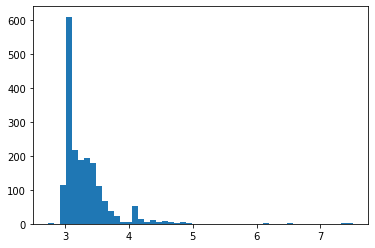

In [10]:
h = plt.hist(np.log10(lengths),51)

In [11]:
np.sum(lengths)

143726002

In [12]:
print('Lengths of the 3 first sequences are {}, {} and {}'.format(
                        *tuple(len(chrt) for chrt in sequences[:3])))

Lengths of the 3 first sequences are 23513712, 25286936 and 28110227


In [13]:
print('First characters are {}, {} and {}'.format(
                        *tuple(chrt[0] for chrt in sequences[:3])))
print('Last characters are {}, {} and {}'.format(
                        *tuple(chrt[-1] for chrt in sequences[:3])))
i = np.random.randint(1000)
print('{}-th characters are {}, {} and {}'.format(i,
                        *tuple(chrt[i] for chrt in sequences[:3])))

First characters are C, C and T
Last characters are g, c and t
586-th characters are g, a and A


In [14]:
print('Occurrences of G are {}, {} and {}'.format(
                        *tuple(chrt.seq.count("G") 
                               for chrt in sequences[:3])))
print('Occurrences of A are {}, {} and {}'.format(
                        *tuple(chrt.seq.count("A")
                               for chrt in sequences[:3])))
print('Occurrences of T are {}, {} and {}'.format(
                        *tuple(chrt.seq.count("T") 
                               for chrt in sequences[:3])))
print('Occurrences of C are {}, {} and {}'.format(
                        *tuple(chrt.seq.count("C") 
                               for chrt in sequences[:3])))

Occurrences of G are 4428980, 4260578 and 4761392
Occurrences of A are 6075234, 5579958 and 6523956
Occurrences of T are 6067775, 5560784 and 6558241
Occurrences of C are 4417944, 4265630 and 4766181


In [15]:
%%time
alphab = ['A', 'G', 'C', 'T', 'S']
oc = {ch: [] for ch in alphab}
for ch in alphab:
    oc['Total_'+ch] =  []
    
for chrt in sequences:
    for ch in alphab:
        try:
            oc[ch].append(chrt.seq.count(ch))
            oc['Total_'+ch].append(len(chrt.seq))
        except:
            try:
                oc[ch].append(chrt.count(ch))
                oc['Total_'+ch].append(len(chrt))

            except:
                pass
            
    
            

CPU times: user 1.66 s, sys: 0 ns, total: 1.66 s
Wall time: 1.66 s


In [16]:

for ch in alphab:
    oc[ch] = np.array(oc[ch])
    oc['Total_'+ch] = np.array(oc['Total_'+ch])

Text(0.5, 0, '# occurences')

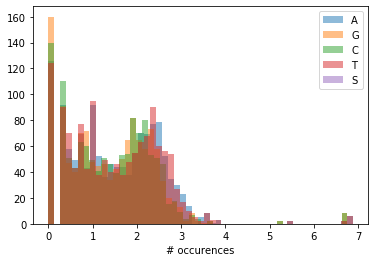

In [17]:

for ch in alphab:
    h = plt.hist(np.log10(oc[ch][oc[ch]>0]),51,alpha = 0.5, label = ch)
    
plt.legend()
plt.xlabel('# occurences')

In [18]:
def gccontent(seq): 
    return 100*(seq.count("G")+seq.count("C"))/len(seq)
    
print('GC contents are {:.2f}, {:.2f} and {:.2f}'.format(
                        *tuple(gccontent(chrt.seq) for chrt in sequences)))

GC contents are 37.62, 33.72 and 33.89


In [19]:
from Bio.SeqUtils import GC
print('GC contents are {:.2f}, {:.2f} and {:.2f}'.format(
                        *tuple(GC(chrt.seq) for chrt in sequences[:3])))

GC contents are 41.78, 42.60 and 41.44


In [20]:
gcC = []
for chrt in sequences:
    for ch in alphab:
        try:
            gcC.append(GC(chrt.seq))    
        except:
            try:
                gcC.append(GC(chrt))
            except:
                pass

Text(0.5, 0, 'GC content')

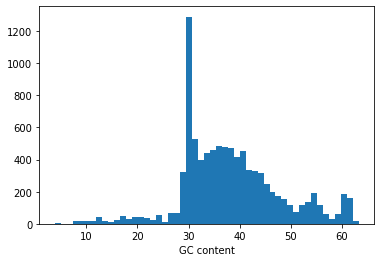

In [21]:
h = plt.hist(gcC, 51)
plt.xlabel('GC content')

The differences are in lowercase and capital letters!! Also there are S and s characters that represent an ambiguous G or C character.

## Machine Learning

First we are going to change the representation to n-gram or k-mer estimators:


In [34]:
def getKmers(sequence, size):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

In [36]:
test = ' '.join(getKmers('AGTCGATAATGC', size = 6))
print(test)

agtcga gtcgat tcgata cgataa gataat ataatg taatgc


In [77]:
from sklearn.feature_extraction.text import CountVectorizer

def kmer_estimator(n, seqA, seqB, full_output = False):
    ''' Caculate the n-gram arrays corresponding to a_text and s_tex
    '''
    
    kmerA = ' '.join(getKmers(seqA, size = n))
    kmerB = ' '.join(getKmers(seqB, size = n))
    
    counter = CountVectorizer( ngram_range = (n,n), )
    
    vocabulary = counter.fit([kmerA, kmerB]).vocabulary_
    
    ngrams = counter.fit_transform([kmerA, kmerB])
    #print(vocabulary)
    if full_output:
        output = ngrams.toarray(), counter
    else:
        output = ngrams.toarray()
    
    return output

In [78]:
testA = "AAGTTAGATCGATTACACTAGT"
testB = "GATTACAATTAGC"
kmer_estimator(3, testA, testB)

array([[1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
        0, 1]])

### Containment

Containment will help us determine similarity between sequences..

$$\mathrm{containment} = \frac{|N_A\cap N_S|}{|N_A|} $$



In [38]:
# Calculate the ngram containment for one answer file/source file pair in a df
def calculate_containment(seqA, seqB, n):
    '''Calculates the containment between a given answer text and its associated source text.
       This function creates a count of ngrams (of a size, n) for each text file in our data.
       Then calculates the containment by finding the ngram count for a given answer text, 
       and its associated source text, and calculating the normalized intersection of those counts.
       :param df: A dataframe with columns,
           'File', 'Task', 'Category', 'Class', 'Text', and 'Datatype'
       :param n: An integer that defines the ngram size
       :param answer_filename: A filename for an answer text in the df, ex. 'g0pB_taskd.txt'
       :return: A single containment value that represents the similarity
           between an answer text and its source text.
    '''
    
    
    kmer_array = kmer_estimator(n, seqA, seqB)
    kmer_min = kmer_array.min(axis=0)
    containment = kmer_min.sum()/kmer_array[0,:].sum()
        
    return containment

In [46]:
print(*tuple(calculate_containment(testA, testB, n) for n in range(2,6)))

0.35 0.16666666666666666 0.0625 0.0


### Longest common sentence

We use dynamic programming

In [24]:
def lcs_norm_word(textA, textB):
    '''Computes the longest common subsequence of words in two texts; returns a normalized value.
       :param answer_text: The pre-processed text for an answer text
       :param source_text: The pre-processed text for an answer's associated source text
       :return: A normalized LCS value'''
    
    A_l = textA.split()
    B_l = textB.split()
    lcsmatrix = np.zeros((len(B_l)+1,len(A_l)+1))
    idx = 0
    for i, word in enumerate(B_l):
        for j, word_A in enumerate(A_l):
            if word == word_A:
                lcsmatrix[i+1,j+1] = lcsmatrix[i,j]+1.0
            else:
                lcsmatrix[i+1,j+1] = np.max([lcsmatrix[i+1,j], 
                                             lcsmatrix[i,j+1]])
                
    return lcsmatrix[-1,-1]/len(A_l)


Now we create containment features

In [39]:

def create_containment_features(sequences, n):
    
    containment_values = []
    
    # iterates through sequences
    for i, seqA in enumerate(sequences):
        for j, seqB in enumerate(sequences[i+1:]):
            c = calculate_containment(seqA, seqB, n)
            containment_values.append(c)
    
    print(str(n)+'-gram containment features created!')
    return containment_values


In [26]:
def create_lcs_features(sequences):
    
    lcs_values = []
    
    for i, seqA in enumerate(sequences):
        for j, seqB in enumerate(sequences[i+1:]):
            # calculate lcs
            lcs = lcs_norm_word(seqA, seqB)
            lcs_values.append(lcs)
            
    print('LCS features created!')
    return lcs_values

In [27]:
strseq = []
for seq in sequences:
    try:
        strseq.append(str(seq.seq))
    except:
        try:
            strseq.append(str(seq))
        except:
            pass
print(len(strseq))

1873


In [64]:
# We are going to test it for first 100 characters
strseqt = [s[:100] for s in strseq[:100]]
print(*tuple( len(s) for s in strseqt[:5]))

100 100 100 100 100


In [65]:
%%time
nkmer_range = range(2,10)

features_list = []

all_features = np.zeros((len(nkmer_range)+1, 
                         len(strseqt)*(len(strseqt)-1)//2))

# Calculate features for containment for nkmers in range
i=0
for n in nkmer_range:
    column_name = 'c_'+str(n)
    features_list.append(column_name)
    # create containment features
    all_features[i]=np.squeeze(create_containment_features(strseqt, n))
    i+=1

# Calculate features for LCS_Norm Words 
features_list.append('lcs_word')
all_features[i]= np.squeeze(create_lcs_features(strseqt))

# create a features dataframe
features_df = pd.DataFrame(np.transpose(all_features), columns=features_list)

# Print all features/columns
print()
print('Features: ', features_list)
print()

2-gram containment features created!
3-gram containment features created!
4-gram containment features created!
5-gram containment features created!
6-gram containment features created!
7-gram containment features created!
8-gram containment features created!
9-gram containment features created!
LCS features created!

Features:  ['c_2', 'c_3', 'c_4', 'c_5', 'c_6', 'c_7', 'c_8', 'c_9', 'lcs_word']

CPU times: user 37 s, sys: 20 ms, total: 37 s
Wall time: 37 s


In [66]:
features_df.head(10)

,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,lcs_word
0,0.510204,0.135417,0.010638,0.000000,0.000000,0.00,0.000000,0.000000,0.0
1,0.642857,0.343750,0.297872,0.282609,0.266667,0.25,0.232558,0.214286,0.0
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1.000000,1.000000,1.0
3,0.510204,0.135417,0.010638,0.000000,0.000000,0.00,0.000000,0.000000,0.0
4,0.642857,0.343750,0.297872,0.282609,0.266667,0.25,0.232558,0.214286,0.0
5,0.316327,0.041667,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0
6,0.153061,0.052083,0.021277,0.000000,0.000000,0.00,0.000000,0.000000,0.0
7,0.551020,0.177083,0.021277,0.000000,0.000000,0.00,0.000000,0.000000,0.0
8,0.173469,0.020833,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0
9,0.142857,0.010417,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0


In [67]:
corr_matrix = features_df.corr().abs().round(2)

# display shows all of a dataframe
display(corr_matrix)

,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,lcs_word
c_2,1.00,0.71,0.26,0.19,0.18,0.17,0.17,0.16,0.08
c_3,0.71,1.00,0.77,0.69,0.64,0.63,0.62,0.61,0.29
c_4,0.26,0.77,1.00,0.97,0.93,0.91,0.90,0.89,0.44
c_5,0.19,0.69,0.97,1.00,0.98,0.97,0.96,0.96,0.49
c_6,0.18,0.64,0.93,0.98,1.00,1.00,0.99,0.99,0.52
c_7,0.17,0.63,0.91,0.97,1.00,1.00,1.00,1.00,0.54
c_8,0.17,0.62,0.90,0.96,0.99,1.00,1.00,1.00,0.55
c_9,0.16,0.61,0.89,0.96,0.99,1.00,1.00,1.00,0.57
lcs_word,0.08,0.29,0.44,0.49,0.52,0.54,0.55,0.57,1.00


Text(0.5, 1.0, 'Train dataset')

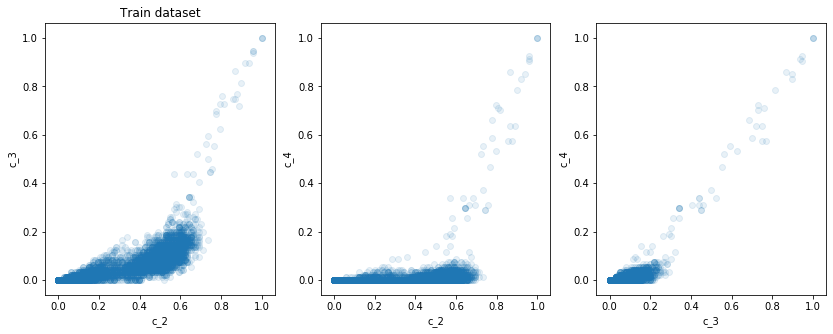

In [72]:
selected_features = ['c_2', 'c_3', 'c_4']
tempx = features_df.loc[:,selected_features].values
fig, ax = plt.subplots(1,3,figsize = (14,5))
ax[0].scatter(tempx[:,0],tempx[:,1], alpha = 0.1)
ax[1].scatter(tempx[:,0],tempx[:,2], alpha = 0.1)
ax[2].scatter(tempx[:,1],tempx[:,2], alpha = 0.1)

ax[0].set_xlabel(selected_features[0])
ax[0].set_ylabel(selected_features[1])

ax[1].set_xlabel(selected_features[0])
ax[1].set_ylabel(selected_features[2])

ax[2].set_xlabel(selected_features[1])
ax[2].set_ylabel(selected_features[2])
ax[0].set_title('Train dataset') 
